## Interactive Gaussian Splat Viewer with Kaolin

We are going to show a really simple way to integrate gaussian splat rendering
with an interactive viewer in [Kaolin Library](https://github.com/NVIDIAGameWorks/kaolin) (see [install docs](https://kaolin.readthedocs.io/en/latest/notes/installation.html)). 

You will need a **python3.8** environment (see modified `envirnoment.yml` in this fork), and and install of the following:

```
pip install ipywidgets ipyevents ipycanvas jupyter matplotlib
pip install kaolin==0.14.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-1.12.1_cu113.html
```

**Let's interactively view your remote checkpoints in a notebook!**

In [1]:
!nvidia-smi

Mon Nov 27 17:19:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:07:00.0 Off |                    0 |
| N/A   38C    P0    80W / 400W |  22423MiB / 40536MiB |     12%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  Off  | 00000000:0F:00.0 Off |                    0 |
| N/A   

In [2]:
!export CUDA_VISIBLE_DEVICES=6

In [5]:
import copy
import ipywidgets
import json
import kaolin
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchvision

# Gaussian splatting dependencies
from utils.graphics_utils import focal2fov
from utils.system_utils import searchForMaxIteration
from gaussian_renderer import render, GaussianModel
from scene.cameras import Camera as GSCamera

from PIL import Image

def log_tensor(t, name, **kwargs):
    print(kaolin.utils.testing.tensor_info(t, name=name, **kwargs))

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Load checkpoint

Assuming you've already run [default training instructions](), for example `python train.py -s /mnt/data/Data/NERF/nerf_synthetic/ficus/`, set the `model_path` to an existing run.

In [6]:
class PipelineParamsNoparse:
    """ Same as PipelineParams but without argument parser. """
    def __init__(self):
        self.convert_SHs_python = False
        self.compute_cov3D_python = False                      
        self.debug = False

        
def load_checkpoint(model_path, sh_degree=3, iteration=-1):
    # Find checkpoint
    checkpt_dir = os.path.join(model_path, "point_cloud")
    if iteration == -1:
        iteration = searchForMaxIteration(checkpt_dir)
    checkpt_path = os.path.join(checkpt_dir, f"iteration_{iteration}", "point_cloud.ply")
    
    # Load guassians
    gaussians = GaussianModel(sh_degree)
    gaussians.load_ply(checkpt_path)                                                 
    return gaussians


def try_load_camera(model_path, idx=0):
    """ Load one of the default cameras for the scene. """
    cam_path = os.path.join(model_path, 'cameras.json')
    if not os.path.exists(cam_path):
        print(f'Could not find saved cameras for the scene at {cam_path}; using default for ficus.')
        return GSCamera(colmap_id=0,
                        R=np.array([[-9.9037e-01,  2.3305e-02, -1.3640e-01], [ 1.3838e-01,  1.6679e-01, -9.7623e-01], [-1.6444e-09, -9.8571e-01, -1.6841e-01]]), 
                        T=np.array([6.8159e-09, 2.0721e-10, 4.03112e+00]), 
                        FoVx=0.69111120, FoVy=0.69111120, 
                        image=torch.zeros((3, 800, 800)),  # fake 
                        gt_alpha_mask=None, image_name='fake', uid=0)
        
    with open(cam_path) as f:
        data = json.load(f)
        raw_camera = data[idx]
        
    tmp = np.zeros((4, 4))
    tmp[:3, :3] = raw_camera['rotation']
    tmp[:3, 3] = raw_camera['position']
    tmp[3, 3] = 1
    name = raw_camera['img_name']
    C2W = np.linalg.inv(tmp)
    R = C2W[:3, :3].transpose()
    T = C2W[:3, 3]
    width = raw_camera['width']
    height = raw_camera['height']
    fovx = focal2fov(raw_camera['fx'], width)
    fovy = focal2fov(raw_camera['fy'], height)
    return GSCamera(colmap_id=0,
                    R=R, T=T, FoVx=fovx, FoVy=fovy, 
                    image=torch.zeros((3, height, width)),  # fake 
                    gt_alpha_mask=None, image_name=name, uid=0)


model_path = '/home/sbonilla/gaussian-splatting/output/f8df57c9-c'
gaussians = load_checkpoint(model_path)
pipeline = PipelineParamsNoparse()
background = torch.tensor([0, 0, 0], dtype=torch.float32, device="cuda")
test_camera = try_load_camera(model_path, idx=0)

## Render and check

for i in range(298): 
    test_camera = try_load_camera(model_path, idx=i)
    render_res = render(test_camera, gaussians, pipeline, background)
    rendering = render_res["render"]
    for k in render_res.keys():
        log_tensor(render_res[k], k, print_stats=True)
    image = (rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu().numpy()
    img = Image.fromarray(image, 'RGB')
    img.save(f'/home/sbonilla/gaussian-splatting/output/f8df57c9-c/gaussian-images/{i}.png')

In [ ]:
for i in range(140): 
    test_camera = try_load_camera(model_path, idx=i)
    render_res = render(test_camera, gaussians, pipeline, background)
    rendering = render_res["render"]
    for k in render_res.keys():
        log_tensor(render_res[k], k, print_stats=True)
    image = (rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu().numpy()
    img = Image.fromarray(image, 'RGB')
    img.save(f'/raid/scratch_not_backed_up/sbonilla/seq3-processed/output/39520b51-6/gaussian-images/{i}.png')

render: [3, 1080, 1350] (torch.float32)[cuda:0]  - [min 0.0794, max 1.1538, mean 0.4649] 
viewspace_points: [152096, 3] (torch.float32)[cuda:0]  - [min 0.0000, max 0.0000, mean 0.0000] 
visibility_filter: [152096] (torch.bool)[cuda:0]  - [min 0.0000, max 1.0000, mean 0.9999] 
radii: [152096] (torch.int32)[cuda:0]  - [min 0.0000, max 1322.0000, mean 27.2899] 


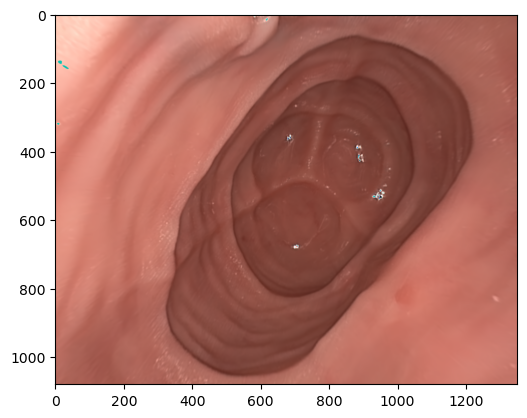

In [7]:
render_res = render(test_camera, gaussians, pipeline, background)
rendering = render_res["render"]
for k in render_res.keys():
    log_tensor(render_res[k], k, print_stats=True)
image = (rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu().numpy()
plt.imshow(image)

## Camera Conversion

Here we'll just write a quick converter from the Gaussian splatting camera to the Kaolin Camera and back. 
We'll check we are still getting the same rendering. 

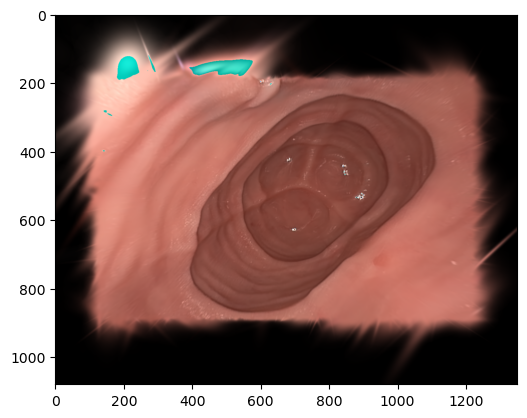

In [8]:
def compute_cam_fov(intrinsics, axis='x'):
    # compute FOV from focal
    aspectScale = intrinsics.width / 2.0
    tanHalfAngle = aspectScale / (intrinsics.focal_x if axis == 'x' else intrinsics.focal_y).item()
    fov = np.arctan(tanHalfAngle) * 2
    return fov

def convert_kaolin_camera(kal_camera):
    """ Convert kaolin camera to GS camera. """
    R = kal_camera.extrinsics.R[0]
    R[1:3] = -R[1:3]
    T = kal_camera.extrinsics.t.squeeze()
    T[1:3] = -T[1:3]
    return GSCamera(colmap_id=0,
                    R=R.transpose(1, 0).cpu().numpy(), 
                    T=T.cpu().numpy(), 
                    FoVx=compute_cam_fov(kal_camera.intrinsics, 'x'), 
                    FoVy=compute_cam_fov(kal_camera.intrinsics, 'y'), 
                    image=torch.zeros((3, kal_camera.height, kal_camera.width)),  # fake 
                    gt_alpha_mask=None,
                    image_name='fake',
                    uid=0)

def convert_gs_camera(gs_camera):
    """ Convert GS camera to Kaolin camera. """
    view_mat = gs_camera.world_view_transform.transpose(1, 0)
    view_mat[1:3] = -view_mat[1:3]
    res = kaolin.render.camera.Camera.from_args(
        view_matrix=view_mat,
        width=gs_camera.image_width, height=gs_camera.image_height,
        fov=gs_camera.FoVx, device='cpu')
    return res

# Test that we can render the same thing
kal_cam = convert_gs_camera(test_camera)
test_cam_back = convert_kaolin_camera(kal_cam)
rendering = render(test_cam_back, gaussians, pipeline, background)["render"]
plt.imshow((rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu().numpy())

# DEBUG 
# print(f'orig view matrix: {test_camera.world_view_transform}')
# print(f'new view_matrix: {test_cam_back.world_view_transform}')
# print(f'orig camera center: {test_camera.camera_center}')
# print(f'new camera center: {test_cam_back.camera_center}')

## Create Interactive Viewer

Now let's view our pretrained Gaussian Splatting scene interactively. 
All we need is a render function that takes a Kaolin camera. Luckily, we already know how to 
convert cameras back and forth.

In [10]:
print(dir(test_camera))

['FoVx', 'FoVy', 'R', 'T', 'T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_call_impl', '_forward_hooks', '_forward_pre_hooks', '_get_backward_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_version', 'add_module', 'apply'

In [11]:
R = test_camera.R

T = test_camera.T

FoVx = test_camera.FoVx

FoVy = test_camera.FoVy

testCamera = GSCamera(colmap_id=0,
                    R=R.transpose(1, 0).cpu().numpy(), 
                    T=T.cpu().numpy(), 
                    FoVx=compute_cam_fov(kal_camera.intrinsics, 'x'), 
                    FoVy=compute_cam_fov(kal_camera.intrinsics, 'y'), 
                    image=torch.zeros((3, kal_camera.height, kal_camera.width)),  # fake 
                    gt_alpha_mask=None,
                    image_name='fake',
                    uid=0) 

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [12]:
kal_cam.intrinsics

PinholeIntrinsics of 1350x1080, params: tensor([[  0.0000,   0.0000, 641.8552, 641.8552]])

In [25]:
print(convert_kaolin_camera(kal_cam).FoVx)

0.7546012467215377


In [9]:
def render_kaolin(kaolin_cam):
    cam = convert_kaolin_camera(kaolin_cam)
    render_res = render(cam, gaussians, pipeline, background)
    rendering = render_res["render"]
    return (rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu()

focus_at = (kal_cam.cam_pos() - 4. * kal_cam.extrinsics.cam_forward()).squeeze()
visualizer = kaolin.visualize.IpyTurntableVisualizer(
    512, 512, copy.deepcopy(kal_cam), render_kaolin, 
    focus_at=focus_at, world_up_axis=2, max_fps=12)
visualizer.show()

Canvas(height=512, width=512)

Output()

## Adding More Control

Interactive viewer in a notebook means we can add other ways to inspect our gaussians. For example, let's filter out gaussians we are showing by their radii.

In [10]:
log_tensor(gaussians.get_scaling, 'scaling after activation', print_stats=True)
log_tensor(gaussians._scaling, 'scaling, raw', print_stats=True)

def selective_render_kaolin(kaolin_cam):
    """Same rendering as above, but we subsample gaussians based on their scale."""
    # Select only the gaussians with radius below value
    scaling = gaussians._scaling.max(dim=1)[0]
    mask = scaling < slider.value
    tmp_gaussians = GaussianModel(gaussians.max_sh_degree)
    tmp_gaussians._xyz = gaussians._xyz[mask, :]
    tmp_gaussians._features_dc = gaussians._features_dc[mask, ...]
    tmp_gaussians._features_rest = gaussians._features_rest[mask, ...]
    tmp_gaussians._opacity = gaussians._opacity[mask, ...]
    tmp_gaussians._scaling = gaussians._scaling[mask, ...]
    tmp_gaussians._rotation = gaussians._rotation[mask, ...]
    tmp_gaussians.active_sh_degree = gaussians.max_sh_degree

    cam = convert_kaolin_camera(kaolin_cam)
    render_res = render(cam, tmp_gaussians, pipeline, background)
    rendering = render_res["render"]
    return (rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu()

def handle_slider(e):
    visualizer.out.clear_output()
    with visualizer.out:
        visualizer.render_update()

# Instantiate visualizer with this custom render function
visualizer = kaolin.visualize.IpyTurntableVisualizer(
    512, 512, copy.deepcopy(kal_cam), selective_render_kaolin, 
    focus_at=focus_at, world_up_axis=2, max_fps=12)

# Instantiate slider to control scaling
scaling = gaussians._scaling.max(dim=1)[0]
slider = ipywidgets.FloatSlider(value=scaling.max().item(),
    min=scaling.min().item(), max=scaling.max().item(),
    step=0.1,
    description='Max scale:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
)
slider.observe(handle_slider, names='value')

visualizer.render_update()
display(visualizer.canvas, visualizer.out, slider)

scaling after activation: [205890, 3] (torch.float32)[cuda:0]  - [min 0.0000, max 16.2771, mean 0.0695] 
scaling, raw: [205890, 3] (torch.float32)[cuda:0]  - [min -45.8216, max 2.7898, mean -5.6437] 


Canvas(height=512, width=512)

Output()

FloatSlider(value=2.7897608280181885, description='Max scale:', max=2.7897608280181885, min=-7.36857795715332,…